# Data Science Final Project: Bag-of-Words Representation
## Group Members: Jiacheng Shi, Boyuan Sun, Xiangru

## Library Used

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from keras.models import load_model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.externals import joblib
from keras.models import Model, Sequential
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.optimizers import SGD, RMSprop, Adam
import pickle
import matplotlib.pyplot as plt
import string
import ast
import re
import warnings
from meter import *
import seaborn as sns
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Data Preprocessing

In [2]:
# read in data
imdb_movie = pd.read_csv('data/imdb_multilabel.csv')

# drop movies with unknown plot
imdb_movie['plot'] = imdb_movie['plot'].apply(lambda sentence: 'drop' if (('plot ' in sentence.lower()) 
                                              and ('unknown' in sentence.lower()))
                                              or (len(sentence.split()) < 100) 
                                              else sentence.lower())
imdb_movie = imdb_movie[imdb_movie['plot'] != 'drop']

# single-label encoding
genre_dict = dict(zip(imdb_movie.genre.unique(), range(20)))
genre_dict['sci-fi'] = 8
imdb_movie['genre_code'] = imdb_movie.genre.replace(genre_dict).values

# multi-label encoded as an array
def multi_label_encoder(all_genre_list):
    """ This function takes a list of genre with a dictionary that keeps track of the index of the genre
    INPUTS
    ------
    all_genre_list: list of genres
    genre_dict: dictionary of indexs
    
    OUTPUTS
    -------
    np array in {0, 1}
    """
    encode = np.zeros(20)
    all_genre_list = ast.literal_eval(all_genre_list)
    for genre in all_genre_list:
        if genre.lower() in genre_dict:
            encode[genre_dict[genre.lower()]] = 1
    return list(encode)

imdb_movie['all_genre_encode'] = imdb_movie['all_genre'].apply(multi_label_encoder)
imdb_movie['plot_list'] = imdb_movie['plot_list'].apply(ast.literal_eval)

# train test split
X_train, X_test, y_train, y_test = train_test_split(imdb_movie['plot'], 
                                                    imdb_movie['all_genre_encode'],
                                                    test_size = 0.2,
                                                    random_state = 209,
                                                    stratify = imdb_movie['genre']
                                                    )

# reshape y_train and y_test
y_train = np.array(list(y_train))
y_test = np.array(list(y_test))

## Models

In [3]:
# bag of words representation
vectorizer = CountVectorizer(stop_words='english')

In [4]:
bag_X_train = vectorizer.fit_transform(X_train)
bag_X_test = vectorizer.transform(X_test)

In [5]:
y_train.shape

(3489, 20)

In [6]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

### Naive Bayes

In [8]:
nb = OneVsRestClassifier(MultinomialNB())
nb.fit(bag_X_train, y_train)

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=1)

In [9]:
naive_train_pred = nb.predict(bag_X_train)
naive_test_pred = nb.predict(bag_X_test)

In [10]:
nb.predict_proba(bag_X_train)[0]

array([  6.02587732e-26,   8.85694317e-34,   1.49873553e-23,
         1.22586750e-22,   8.02465115e-22,   1.97463553e-16,
         1.50755266e-28,   4.33454840e-25,   1.00000000e+00,
         1.00233714e-11,   9.02363700e-16,   4.90038462e-15,
         1.00000000e+00,   3.95075533e-22,   1.08958418e-15,
         5.68696002e-11,   1.00000000e+00,   1.84119608e-14,
         1.44924363e-02,   6.99786802e-11])

In [7]:
# load the model from disk
filename = 'nb_bag.pkl'
loaded_nb = pickle.load(open(filename, 'rb'))

In [8]:
naive_train_pred = loaded_nb.predict(bag_X_train)
naive_test_pred = loaded_nb.predict(bag_X_test)

In [9]:
# evaluation
print('Naive Bayes Avg Accuracy on train : {}'.format(score(y_train, naive_train_pred, 'avg')))
print('Naive Bayes Exact Accuracy on train : {}'.format(score(y_train, naive_train_pred, 'exact')))
print('Naive Bayes Precision on train : {}'.format(score(y_train, naive_train_pred, 'precision')))
print('Naive Bayes Recall on train : {}'.format(score(y_train, naive_train_pred, 'recall')))
print('Naive Bayes Hit Rate on train : {}'.format(score(y_train, naive_train_pred, 'hit')))
print('Naive Bayes F1 Score on train : {}'.format(score(y_train, naive_train_pred, 'f1')))

Naive Bayes Avg Accuracy on train : 0.9792777300085984
Naive Bayes Exact Accuracy on train : 0.7179707652622528
Naive Bayes Precision on train : 0.9315267823056468
Naive Bayes Recall on train : 0.9288957083925142
Naive Bayes Hit Rate on train : 0.996847234164517
Naive Bayes F1 Score on train : 0.9302093848711593


In [10]:
# evaluation
print('Naive Bayes Avg Accuracy on test : {}'.format(score(y_test, naive_test_pred, 'avg')))
print('Naive Bayes Exact Accuracy on test : {}'.format(score(y_test, naive_test_pred, 'exact')))
print('Naive Bayes Precision on test : {}'.format(score(y_test, naive_test_pred, 'precision')))
print('Naive Bayes Recall on test : {}'.format(score(y_test, naive_test_pred, 'recall')))
print('Naive Bayes Hit Rate on test : {}'.format(score(y_test, naive_test_pred, 'hit')))
print('Naive Bayes F1 Score on test : {}'.format(score(y_test, naive_test_pred, 'f1')))

Naive Bayes Avg Accuracy on test : 0.8965063001145475
Naive Bayes Exact Accuracy on test : 0.13058419243986255
Naive Bayes Precision on test : 0.7681719171017082
Naive Bayes Recall on test : 0.4236525949790833
Naive Bayes Hit Rate on test : 0.9083619702176403
Naive Bayes F1 Score on test : 0.5461173566601978


In [11]:
nb_metrics = metrics_df(y_train, y_test, naive_train_pred, naive_test_pred)

In [377]:
# save model
pickle.dump(nb, open(filename, 'wb'))

### Random Forests

In [365]:
rf_tuning_parameters = {'estimator__n_estimators':[50, 100, 200], 
                        'estimator__max_depth':[100, 200, 500]}

In [366]:
rf = OneVsRestClassifier(RandomForestClassifier())
rf = GridSearchCV(rf, param_grid = rf_tuning_parameters, cv=5, n_jobs=-1)
rf.fit(bag_X_train, y_train)
rf_train_pred = rf.predict(bag_X_train)
rf_test_pred = rf.predict(bag_X_test)

In [369]:
rf.best_params_

{'estimator__max_depth': 200, 'estimator__n_estimators': 100}

In [12]:
# load the model from disk
filename = 'rf_bag.pkl'
loaded_rf = pickle.load(open(filename, 'rb'))

In [13]:
rf_train_pred = loaded_rf.predict(bag_X_train)
rf_test_pred = loaded_rf.predict(bag_X_test)

In [14]:
# evaluation
print('Random Forest Avg Accuracy on train : {}'.format(score(y_train, rf_train_pred, 'avg')))
print('Random Forest Exact Accuracy on train : {}'.format(score(y_train, rf_train_pred, 'exact')))
print('Random Forest Precision on train : {}'.format(score(y_train, rf_train_pred, 'precision')))
print('Random Forest Recall on train : {}'.format(score(y_train, rf_train_pred, 'recall')))
print('Random Forest Hit Rate on train : {}'.format(score(y_train, rf_train_pred, 'hit')))
print('Random Forest F1 Score on train : {}'.format(score(y_train, rf_train_pred, 'f1')))

Random Forest Avg Accuracy on train : 0.9999570077386072
Random Forest Exact Accuracy on train : 0.999140154772141
Random Forest Precision on train : 1.0
Random Forest Recall on train : 0.9993218893368867
Random Forest Hit Rate on train : 1.0
Random Forest F1 Score on train : 0.999660829670935


In [15]:
# evaluation
print('Random Forest Avg Accuracy on test : {}'.format(score(y_test, rf_test_pred, 'avg')))
print('Random Forest Exact Accuracy on test : {}'.format(score(y_test, rf_test_pred, 'exact')))
print('Random Forest Precision on test : {}'.format(score(y_test, rf_test_pred, 'precision')))
print('Random Forest Recall on test : {}'.format(score(y_test, rf_test_pred, 'recall')))
print('Random Forest Hit Rate on test : {}'.format(score(y_test, rf_test_pred, 'hit')))
print('Random Forest F1 Score on test : {}'.format(score(y_test, rf_test_pred, 'f1')))

Random Forest Avg Accuracy on test : 0.8701603665521191
Random Forest Exact Accuracy on test : 0.05154639175257732
Random Forest Precision on test : 0.672163815507625
Random Forest Recall on test : 0.1545947643964105
Random Forest Hit Rate on test : 0.6838487972508591
Random Forest F1 Score on test : 0.25137448638574794


In [16]:
rf_metrics = metrics_df(y_train, y_test, rf_train_pred, rf_test_pred)

In [378]:
# save model
pickle.dump(rf, open(filename, 'wb'))

### SVM

In [359]:
svm_tuning_parameters = {'estimator__C': [5, 50, 100, 1000],
                         'estimator__kernel': ['rbf']}

In [360]:
svm = OneVsRestClassifier(SVC())
svm = GridSearchCV(svm, param_grid = svm_tuning_parameters, cv=5, n_jobs=-1)
svm.fit(bag_X_train, y_train)
svm_train_pred = svm.predict(bag_X_train)
svm_test_pred = svm.predict(bag_X_test)

In [17]:
# load the model from disk
filename = 'svm_bag.pkl'
loaded_svm = pickle.load(open(filename, 'rb'))

In [18]:
svm_train_pred = loaded_svm.predict(bag_X_train)
svm_test_pred = loaded_svm.predict(bag_X_test)

In [19]:
loaded_svm.best_params_

{'estimator__C': 1000, 'estimator__kernel': 'rbf'}

In [20]:
# evaluation
print('SVM Avg Accuracy on train : {}'.format(score(y_train, svm_train_pred, 'avg')))
print('SVM Exact Accuracy on train : {}'.format(score(y_train, svm_train_pred, 'exact')))
print('SVM Precision on train : {}'.format(score(y_train, svm_train_pred, 'precision')))
print('SVM Recall on train : {}'.format(score(y_train, svm_train_pred, 'recall')))
print('SVM Hit Rate on train : {}'.format(score(y_train, svm_train_pred, 'hit')))
print('SVM F1 Score on train : {}'.format(score(y_train, svm_train_pred, 'f1')))

SVM Avg Accuracy on train : 1.0
SVM Exact Accuracy on train : 1.0
SVM Precision on train : 1.0
SVM Recall on train : 1.0
SVM Hit Rate on train : 1.0
SVM F1 Score on train : 1.0


In [21]:
# evaluation
print('SVM Avg Accuracy on test : {}'.format(score(y_test, svm_test_pred, 'avg')))
print('SVM Exact Accuracy on test : {}'.format(score(y_test, svm_test_pred, 'exact')))
print('SVM Precision on test : {}'.format(score(y_test, svm_test_pred, 'precision')))
print('SVM Recall on test : {}'.format(score(y_test, svm_test_pred, 'recall')))
print('SVM Hit Rate on test : {}'.format(score(y_test, svm_test_pred, 'hit')))
print('SVM F1 Score on test : {}'.format(score(y_test, svm_test_pred, 'f1')))

SVM Avg Accuracy on test : 0.8882016036655211
SVM Exact Accuracy on test : 0.09392898052691867
SVM Precision on test : 0.6848130894195936
SVM Recall on test : 0.49363130857564047
SVM Hit Rate on test : 0.9209621993127147
SVM F1 Score on test : 0.5737142660867198


In [22]:
svm_metrics = metrics_df(y_train, y_test, svm_train_pred, svm_test_pred)

In [379]:
# save model
pickle.dump(svm, open(filename, 'wb'))

### Logistic Regression

In [40]:
lr = OneVsRestClassifier(LogisticRegressionCV(cv = 5))
lr.fit(bag_X_train, y_train)
lr_train_pred = lr.predict(bag_X_train)
lr_test_pred = lr.predict(bag_X_test)

In [23]:
# load the model from disk
filename = 'lr_bag.pkl'
loaded_lr = pickle.load(open(filename, 'rb'))

In [24]:
lr_train_pred = loaded_lr.predict(bag_X_train)
lr_test_pred = loaded_lr.predict(bag_X_test)

In [25]:
# evaluation
print('Logistic Regression Avg Accuracy on train : {}'.format(score(y_train, lr_train_pred, 'avg')))
print('Logistic Regression Exact Accuracy on train : {}'.format(score(y_train, lr_train_pred, 'exact')))
print('Logistic Regression Precision on train : {}'.format(score(y_train, lr_train_pred, 'precision')))
print('Logistic Regression Recall on train : {}'.format(score(y_train, lr_train_pred, 'recall')))
print('Logistic Regression Hit Rate on train : {}'.format(score(y_train, lr_train_pred, 'hit')))
print('Logistic Regression F1 score on train : {}'.format(score(y_train, lr_train_pred, 'f1')))

Logistic Regression Avg Accuracy on train : 0.9929492691315562
Logistic Regression Exact Accuracy on train : 0.8747492118085411
Logistic Regression Precision on train : 0.9950027359503879
Logistic Regression Recall on train : 0.9822574263121329
Logistic Regression Hit Rate on train : 0.9988535396961881
Logistic Regression F1 score on train : 0.9885890033507853


In [26]:
# evaluation
print('Logistic Regression Avg Accuracy on test : {}'.format(score(y_test, lr_test_pred, 'avg')))
print('Logistic Regression Exact Accuracy on test : {}'.format(score(y_test, lr_test_pred, 'exact')))
print('Logistic Regression Precision on test : {}'.format(score(y_test, lr_test_pred, 'precision')))
print('Logistic Regression Recall on test : {}'.format(score(y_test, lr_test_pred, 'recall')))
print('Logistic Regression Hit Rate on test : {}'.format(score(y_test, lr_test_pred, 'hit')))
print('Logistic Regression F1 on test : {}'.format(score(y_test, lr_test_pred, 'f1')))

Logistic Regression Avg Accuracy on test : 0.8963917525773195
Logistic Regression Exact Accuracy on test : 0.11798396334478808
Logistic Regression Precision on test : 0.7402333343216527
Logistic Regression Recall on test : 0.46579822650702135
Logistic Regression Hit Rate on test : 0.9106529209621993
Logistic Regression F1 on test : 0.5717916272298719


In [27]:
lr_metrics = metrics_df(y_train, y_test, lr_train_pred, lr_test_pred)

In [380]:
# save model
pickle.dump(lr, open(filename, 'wb'))

### Neural Network

In [7]:
model = Sequential()
model.add(Dense(512, input_dim = bag_X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(20, activation='sigmoid'))

In [101]:
model.compile(optimizer=Adam(lr=0.0005, decay = 1e-6), loss='binary_crossentropy', metrics=['acc'])

In [102]:
dense_history = model.fit(bag_X_train, y_train,
                batch_size=128,
                epochs=10, validation_data = (bag_X_test, y_test))

Train on 3489 samples, validate on 873 samples
Epoch 1/10
3489/3489 [==============================] - 25s 7ms/step - loss: 0.4877 - acc: 0.8076 - val_loss: 0.3900 - val_acc: 0.8588
Epoch 2/10
3489/3489 [==============================] - 19s 6ms/step - loss: 0.3406 - acc: 0.8714 - val_loss: 0.3216 - val_acc: 0.8786
Epoch 3/10
3489/3489 [==============================] - 19s 5ms/step - loss: 0.2440 - acc: 0.9061 - val_loss: 0.2739 - val_acc: 0.8962
Epoch 4/10
3489/3489 [==============================] - 19s 5ms/step - loss: 0.1703 - acc: 0.9367 - val_loss: 0.2569 - val_acc: 0.9017
Epoch 5/10
3489/3489 [==============================] - 21s 6ms/step - loss: 0.1231 - acc: 0.9566 - val_loss: 0.2607 - val_acc: 0.9033
Epoch 6/10
3489/3489 [==============================] - 24s 7ms/step - loss: 0.0909 - acc: 0.9698 - val_loss: 0.2660 - val_acc: 0.9043
Epoch 7/10
3489/3489 [==============================] - 25s 7ms/step - loss: 0.0687 - acc: 0.9787 - val_loss: 0.2783 - val_acc: 0.9057
Epoch 8/

In [8]:
# load the model from disk
filename = 'nn_bag.pkl'
loaded_nn = load_model(filename)

In [9]:
nn_train_pred = loaded_nn.predict(bag_X_train)
nn_test_pred = loaded_nn.predict(bag_X_test)

In [10]:
# evaluation
print('Fully-connected Avg Accuracy on train : {}'.format(score_thres(y_train, nn_train_pred, method = 'avg')))
print('Fully-connected Exact Accuracy on train : {}'.format(score_thres(y_train, nn_train_pred, method = 'exact')))
print('Fully-connected Precision on train : {}'.format(score_thres(y_train, nn_train_pred, method = 'precision')))
print('Fully-connected Recall on train : {}'.format(score_thres(y_train, nn_train_pred, method = 'recall')))
print('Fully-connected Hit Rate on train : {}'.format(score_thres(y_train, nn_train_pred, method = 'hit')))
print('Fully-connected F1 score on train : {}'.format(score_thres(y_train, nn_train_pred, method = 'f1')))

Fully-connected Avg Accuracy on train : 0.9997277156778447
Fully-connected Exact Accuracy on train : 0.9951275437087991
Fully-connected Precision on train : 0.9997777777777778
Fully-connected Recall on train : 0.9967043006212576
Fully-connected Hit Rate on train : 1.0
Fully-connected F1 score on train : 0.9982386734728393


In [11]:
# evaluation
print('Fully-connected Avg Accuracy on train : {}'.format(score_thres(y_test, nn_test_pred, method = 'avg')))
print('Fully-connected Exact Accuracy on train : {}'.format(score_thres(y_test, nn_test_pred, method = 'exact')))
print('Fully-connected Precision on train : {}'.format(score_thres(y_test, nn_test_pred, method = 'precision')))
print('Fully-connected Recall on train : {}'.format(score_thres(y_test, nn_test_pred, method = 'recall')))
print('Fully-connected Hit Rate on train : {}'.format(score_thres(y_test, nn_test_pred, method = 'hit')))
print('Fully-connected F1 score on train : {}'.format(score_thres(y_test, nn_test_pred, method = 'f1')))

Fully-connected Avg Accuracy on train : 0.9069873997709049
Fully-connected Exact Accuracy on train : 0.16494845360824742
Fully-connected Precision on train : 0.7918182031327549
Fully-connected Recall on train : 0.49986248869225686
Fully-connected Hit Rate on train : 0.9392898052691867
Fully-connected F1 score on train : 0.6128452954585005


In [12]:
nn_metrics = metrics_thres_df(y_train, y_test, nn_train_pred, nn_test_pred)

In [103]:
# save model
filename = 'nn_bag.pkl'
model.save(filename)

### Plot

In [33]:
score_df = pd.DataFrame({'Naive Bayes': nb_metrics,
                         'Random Forest': rf_metrics, 
                         'SVM': svm_metrics,
                         'Logistic Regression': lr_metrics,
                        'Neural Network': nn_metrics})

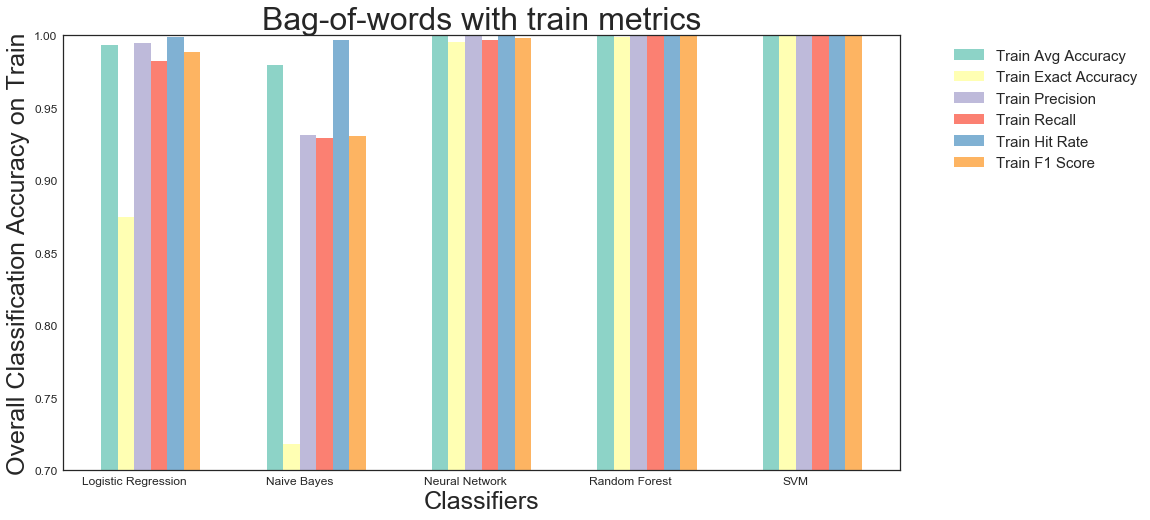

In [37]:
bar_width = 0.1
plt.figure(figsize = (15,8))
for i,idx in enumerate(score_df.index[:6]):
    plt.bar(np.arange(len(score_df.columns))+i*bar_width, score_df.loc[idx], 
            bar_width, color=sns.color_palette('Set3')[i], label=idx)
plt.xticks(np.arange(len(score_df.columns))+0.15, score_df.columns)
plt.ylabel('Overall Classification Accuracy on Train', fontsize = 25)
plt.xlabel('Classifiers', fontsize = 25)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize = 15)
plt.ylim(0.7,1.0)
plt.title('Bag-of-words with train metrics', fontsize = 32)
plt.show()

In [41]:
score_df

,Logistic Regression,Naive Bayes,Neural Network,Random Forest,SVM
Train Avg Accuracy,0.992949,0.979278,0.999728,0.999957,1.000000
Train Exact Accuracy,0.874749,0.717971,0.995128,0.999140,1.000000
Train Precision,0.995003,0.931527,0.999778,1.000000,1.000000
Train Recall,0.982257,0.928896,0.996704,0.999322,1.000000
Train Hit Rate,0.998854,0.996847,1.000000,1.000000,1.000000
Train F1 Score,0.988589,0.930209,0.998239,0.999661,1.000000
Test Avg Accuracy,0.896392,0.896506,0.906987,0.870160,0.888202
Test Exact Accuracy,0.117984,0.130584,0.164948,0.051546,0.093929
Test Precision,0.740233,0.768172,0.791818,0.672164,0.684813
Test Recall,0.465798,0.423653,0.499862,0.154595,0.493631


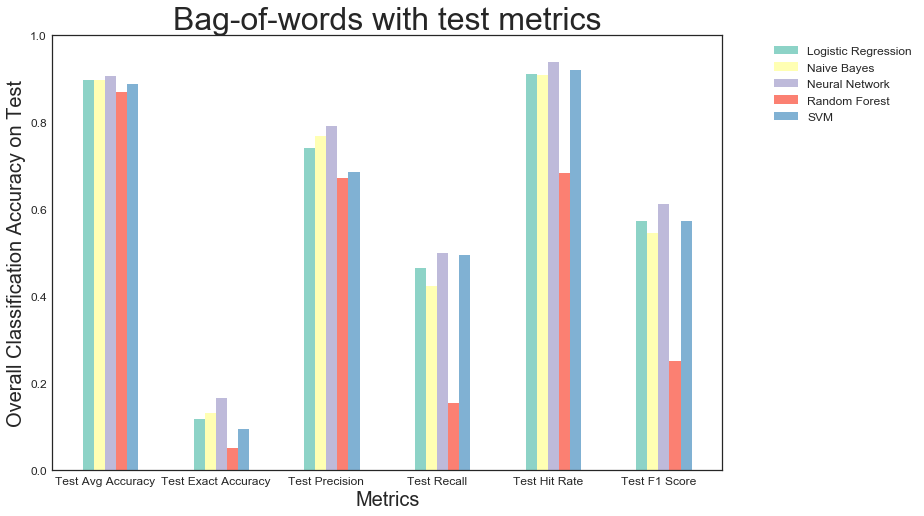

In [38]:
bar_width = 0.1
plt.figure(figsize = (12,8))
for idx,col in enumerate(score_df.columns):
    plt.bar(np.arange(len(score_df.index[6:12]))+idx*bar_width, score_df[[col]].values[6:12], 
            bar_width, color=sns.color_palette("Set3")[idx], label=col)
plt.xticks(np.arange(len(score_df.index[6:12]))+0.15, score_df.index[6:12])
plt.ylabel('Overall Classification Accuracy on Test', fontsize = 20)
plt.xlabel('Metrics', fontsize = 20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.ylim(0,1)
plt.title('Bag-of-words with test metrics', fontsize = 32)
plt.show()

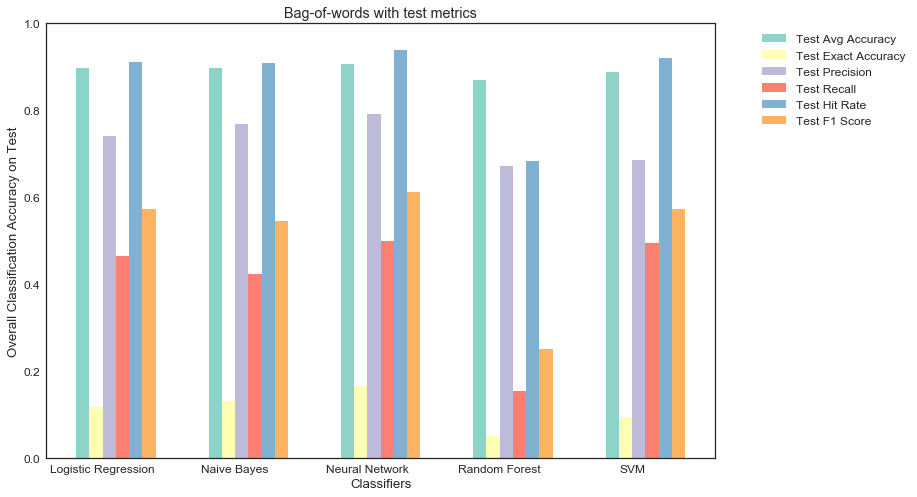

In [39]:
bar_width = 0.1
plt.figure(figsize = (12,8))
for i,idx in enumerate(score_df.index[6:12]):
    plt.bar(np.arange(len(score_df.columns))+i*bar_width, score_df.loc[idx], 
            bar_width, color=sns.color_palette("Set3")[i], label=idx)
plt.xticks(np.arange(len(score_df.columns))+0.15, score_df.columns)
plt.ylabel('Overall Classification Accuracy on Test')
plt.xlabel('Classifiers')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.ylim(0,1)
plt.title('Bag-of-words with test metrics')
plt.show()

Genre sport: 27 correct out of 42
Genre music: 16 correct out of 43
Genre biography: 12 correct out of 80
Genre animation: 16 correct out of 62
Genre history: 12 correct out of 56
Genre war: 40 correct out of 69
Genre western: 24 correct out of 43
Genre musical: 9 correct out of 57
Genre sci_fi: 80 correct out of 120
Genre fantasy: 68 correct out of 128
Genre family: 73 correct out of 125
Genre mystery: 24 correct out of 89
Genre adventure: 145 correct out of 230
Genre horror: 44 correct out of 89
Genre crime: 81 correct out of 156
Genre thriller: 165 correct out of 254
Genre action: 161 correct out of 233
Genre romance: 107 correct out of 197
Genre comedy: 208 correct out of 302
Genre drama: 367 correct out of 461


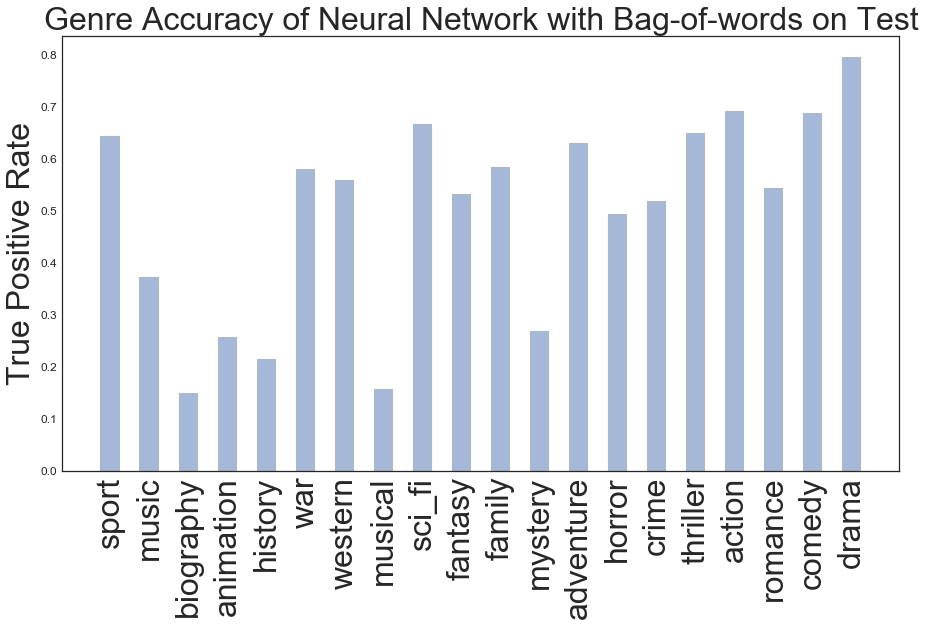

In [13]:
genre_acc(y_test, nn_test_pred, genre_dict, "Genre Accuracy of Neural Network with Bag-of-words on Test", is_neural_net = True, thres = 0.5)